In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

pd.options.mode.chained_assignment = None

DATA_URL = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"

try:
    df = pd.read_csv(
        DATA_URL, sep="\t", header=None, names=["label", "message"], encoding="latin-1"
    )
except Exception:
    data = {
        "label": ["ham", "spam", "ham", "spam"],
        "message": [
            "Go until jurong point",
            "Free entry in 2 a wkly comp",
            "Ok lar... Joking wif u oni",
            "WINNER!! 500 free credit text NOW",
        ],
    }
    df = pd.DataFrame(data)

df["label"] = df["label"].map({"ham": 0, "spam": 1})

try:
    stopwords_df = pd.read_csv(
        "https://raw.githubusercontent.com/stopwords-iso/stopwords-en/master/stopwords-en.txt",
        header=None,
    )
    stopwords = set(stopwords_df[0].values)
except Exception:
    stopwords = set()



In [2]:


def preprocess_text(text):
    """Cleans text by lowercasing, removing punctuation, and stopwords."""
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = " ".join([word for word in text.split() if word not in stopwords])
    return text

In [3]:

df["cleaned_message"] = df["message"].apply(preprocess_text)

X_text = df["cleaned_message"]
y = df["label"]

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

In [4]:

def evaluate_model(model, X_train, y_train, X_test, y_test, name):
    """Evaluates and prints performance metrics."""
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    cm = confusion_matrix(y_test, y_test_pred)

    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    print("\nConfusion Matrix (Test Set):\n", cm)
    return train_acc, test_acc, cm



In [5]:

stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

evaluate_model(stump, X_train, y_train, X_test, y_test, "Decision Stump")

y_train_signed = np.where(y_train == 0, -1, 1)
y_test_signed = np.where(y_test == 0, -1, 1)

N = X_train.shape[0]
T = 15
D = np.full(N, 1 / N)
H_final = np.zeros(N)

error_history = []
alpha_history = []
model_history = []

for t in range(T):
    print(f"\n[Iteration {t + 1}]")

    h_t = DecisionTreeClassifier(max_depth=1, random_state=t)
    h_t.fit(X_train, y_train, sample_weight=D)

    y_pred_01 = h_t.predict(X_train)

    y_pred_signed = np.where(y_pred_01 == 0, -1, 1)

    misclassified_indices = np.where(y_pred_signed != y_train_signed)[0]

    epsilon_t = np.sum(D[misclassified_indices])

    if epsilon_t == 0:
        print("Weighted error is 0. Stopping AdaBoost early.")
        break
    if epsilon_t >= 0.5:
        print(f"Weighted error is {epsilon_t:.4f}. Stump is too weak. Stopping.")
        break

    alpha_t = 0.5 * np.log((1 - epsilon_t) / epsilon_t)

    H_final += alpha_t * y_pred_signed

    print(f"Weighted Error (ε): {epsilon_t:.4f}")
    print(f"Alpha (α): {alpha_t:.4f}")

    print(
        f"Misclassified samples ({len(misclassified_indices)} total): {misclassified_indices[:5]}..."
    )
    print(
        f"Initial weights of these samples: {D[misclassified_indices[:5]].round(6)}..."
    )

    D *= np.exp(-alpha_t * y_train_signed * y_pred_signed)
    D /= np.sum(D)

    error_history.append(epsilon_t)
    alpha_history.append(alpha_t)
    model_history.append((alpha_t, h_t))  # Store (alpha, stump model) tuple



Train Accuracy: 0.8892
Test Accuracy:  0.8897

Confusion Matrix (Test Set):
 [[965   1]
 [122  27]]

[Iteration 1]
Weighted Error (ε): 0.1108
Alpha (α): 1.0411
Misclassified samples (494 total): [ 9 15 22 31 39]...
Initial weights of these samples: [0.000224 0.000224 0.000224 0.000224 0.000224]...

[Iteration 2]
Weighted Error (ε): 0.4230
Alpha (α): 0.1552
Misclassified samples (509 total): [ 9 15 22 31 39]...
Initial weights of these samples: [0.001012 0.001012 0.001012 0.001012 0.001012]...

[Iteration 3]
Weighted Error (ε): 0.4304
Alpha (α): 0.1401
Misclassified samples (3859 total): [0 1 2 3 4]...
Initial weights of these samples: [0.000109 0.000109 0.000109 0.000109 0.000109]...

[Iteration 4]
Weighted Error (ε): 0.4317
Alpha (α): 0.1374
Misclassified samples (531 total): [ 9 15 22 31 39]...
Initial weights of these samples: [0.00105 0.00105 0.00105 0.00105 0.00105]...

[Iteration 5]
Weighted Error (ε): 0.4404
Alpha (α): 0.1198
Misclassified samples (3859 total): [0 1 2 3 4]...
In

Train Accuracy: 0.8923
Test Accuracy:  0.8933

Confusion Matrix (Test Set):
 [[965   1]
 [118  31]]


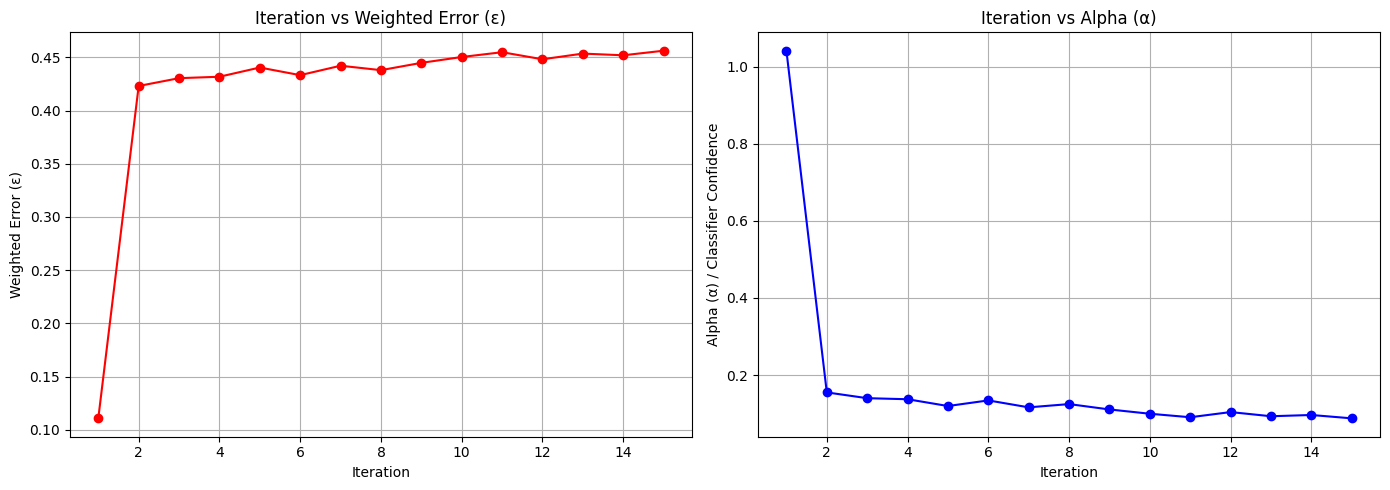

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Train Accuracy: 0.9055
Test Accuracy:  0.9022

Confusion Matrix (Test Set):
 [[964   2]
 [107  42]]


In [6]:

def manual_ada_predict(X, model_history):
    """Aggregates predictions from all weak learners."""
    N_samples = X.shape[0]
    final_pred_signed = np.zeros(N_samples)

    for alpha, h_t in model_history:
        y_pred_01 = h_t.predict(X)
        y_pred_signed = np.where(y_pred_01 == 0, -1, 1)
        final_pred_signed += alpha * y_pred_signed

    final_pred_01 = np.where(final_pred_signed > 0, 1, 0)
    return final_pred_01


y_manual_pred_train = manual_ada_predict(X_train, model_history)
y_manual_pred_test = manual_ada_predict(X_test, model_history)

manual_train_acc = accuracy_score(y_train, y_manual_pred_train)
manual_test_acc = accuracy_score(y_test, y_manual_pred_test)
manual_cm = confusion_matrix(y_test, y_manual_pred_test)

print(f"Train Accuracy: {manual_train_acc:.4f}")
print(f"Test Accuracy:  {manual_test_acc:.4f}")
print("\nConfusion Matrix (Test Set):\n", manual_cm)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
iterations = np.arange(1, len(error_history) + 1)

ax1.plot(iterations, error_history, marker="o", linestyle="-", color="red")
ax1.set_title("Iteration vs Weighted Error (ε)")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Weighted Error (ε)")
ax1.grid(True)

ax2.plot(iterations, alpha_history, marker="o", linestyle="-", color="blue")
ax2.set_title("Iteration vs Alpha (α)")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Alpha (α) / Classifier Confidence")
ax2.grid(True)

plt.tight_layout()
plt.show()


ada_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.6,
    random_state=42,
    algorithm="SAMME",
)

ada_clf.fit(X_train, y_train)

sklearn_train_acc, sklearn_test_acc, sklearn_cm = evaluate_model(
    ada_clf, X_train, y_train, X_test, y_test, "Sklearn AdaBoost (100 Est.)"
)


In [7]:

print(f"Manual AdaBoost Test Acc (15 rounds): {manual_test_acc:.4f}")
print(f"Sklearn AdaBoost Test Acc (100 rounds): {sklearn_test_acc:.4f}")

Manual AdaBoost Test Acc (15 rounds): 0.8933
Sklearn AdaBoost Test Acc (100 rounds): 0.9022
